# Jupyter Setup

In [1]:
# automatically reload imported modules on use
%load_ext autoreload
%autoreload 2

# plot inline
%matplotlib inline

# Imports

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from gym.envs.classic_control import PendulumEnv

from forward_models.model import Normalizer, ForwardModel
from forward_models.rollout import Rollout

# Setup

In [3]:
# enable TF Eager
tf.enable_eager_execution()

In [4]:
# define job directory with saved checkpoints
job_dir = '/Users/fomoro/jobs/forward_models/1543249521'
max_episode_steps = 200
episodes = 4

In [5]:
# create an environment
env = PendulumEnv()

# create a rollout
rollout = Rollout(env, max_episode_steps=max_episode_steps)

# sample rollouts
states, actions, rewards, next_states, weights = rollout(
     lambda state: env.action_space.sample(),
     episodes=episodes)

# compute deltas between the next state and the current state
deltas = next_states - states

# create normalizers for the features and targets
# NOTE: it's important that the statistics match those used during training
#       they will be restored from the checkpoint
state_normalizer = Normalizer(
    loc=states.mean(axis=(0, 1)),
    scale=states.std(axis=(0, 1)))
delta_normalizer = Normalizer(
    loc=deltas.mean(axis=(0, 1)),
    scale=deltas.std(axis=(0, 1)))
action_normalizer = Normalizer(
    loc=actions.mean(axis=(0, 1)),
    scale=actions.std(axis=(0, 1)))

# create the forward model
model = ForwardModel(output_units=env.observation_space.shape[-1])

# create a checkpoint with references to all objects to restore
checkpoint = tf.train.Checkpoint(
    state_normalizer=state_normalizer,
    delta_normalizer=delta_normalizer,
    action_normalizer=action_normalizer,
    model=model)

# restore the latest checkpoint in job_dir
checkpoint_path = tf.train.latest_checkpoint(job_dir)
assert checkpoint_path is not None, 'job_dir must contain checkpoint'
checkpoint.restore(checkpoint_path)

# Instantaneous Evaluation

The instantaneous evaluation is the simplest form of evaluation. For each step, predict the next state given a _ground truth_ state and action. Typically we only use this for spot-checking the predictions as it does not reflect the intended usage of the forward model.

In [6]:
# normalize features
states_norm = state_normalizer(states)
actions_norm = action_normalizer(actions)

# compute a forward pass while resetting the RNN state
deltas_norm_pred = model(states_norm, actions_norm, training=False, reset_state=True)

# de-normalize the predicted delta
deltas_pred = delta_normalizer.invert(deltas_norm_pred)

# add the prior states to the unnormalized deltas
next_states_pred = states + deltas_pred.numpy()

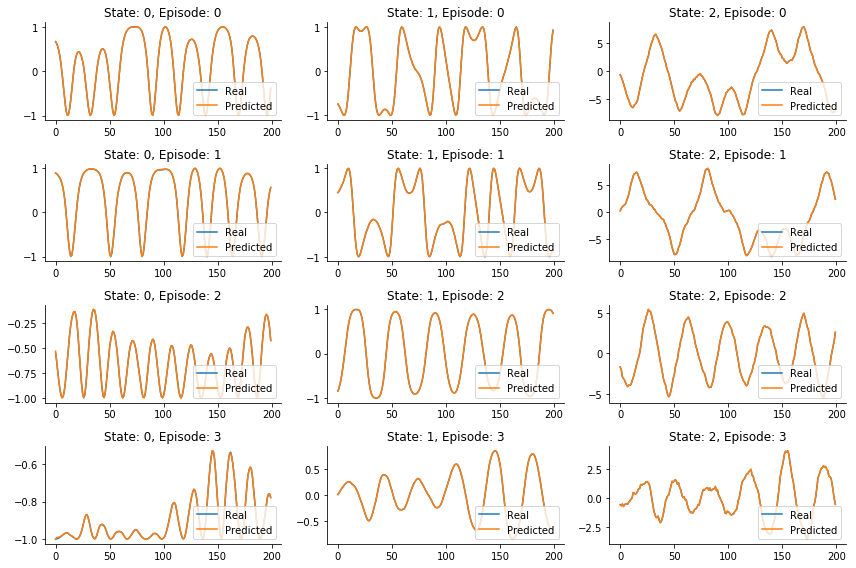

In [7]:
# plot the instantaneous predictions for each episode and state
state_size = env.observation_space.shape[-1]
fig, axes = plt.subplots(episodes, state_size, figsize=(12, 8))
for state_dim in range(state_size):
    for episode in range(episodes):
        ax = axes[episode, state_dim]
        ax.plot(next_states[episode, :, state_dim], label='Real')
        ax.plot(next_states_pred[episode, :, state_dim], label='Predicted')
        ax.legend(loc='lower right')
        ax.set_title('State: {}, Episode: {}'.format(state_dim, episode))
sns.despine()
plt.tight_layout()

# Rollout Evaluation

The rollout evaluation is the most important because it mimics the usage of the forward model as an environment for an agent. For the first timestep, predict the next state given a ground truth state and action. For all subsequent steps, predict the next state given the previously predicted state and a ground truth action. This evaluation stresses the temporal generalization of the model. A good rollout is accurate for some number of steps before diverging from the ground truth states.

In [8]:
# initialize the current state and action from data
curr_state = states[:, 0][:, None]
curr_action = actions[:, 0][:, None]

next_states_pred_list = []
for step in range(max_episode_steps):
    # normalize the features
    curr_state_norm = state_normalizer(curr_state)
    curr_action_norm = action_normalizer(curr_action)
    
    # reset the RNN state on the first step, but not subsequent steps of the episode
    reset_state = (step == 0)

    # compute a forward pass
    curr_delta_norm_pred = model(
        curr_state_norm,
        curr_action_norm,
        training=False,
        reset_state=reset_state)
    
    # de-normalize the predicted delta
    curr_delta_pred = delta_normalizer.invert(curr_delta_norm_pred)
    
    # add the prior states to the unnormalized deltas
    curr_pred = curr_state + curr_delta_pred
    next_states_pred_list.append(curr_pred.numpy())

    # set the current state to the predicted next state and set the current action from data
    curr_state = curr_pred
    curr_action = actions[:, step][:, None]

next_states_pred = np.concatenate(next_states_pred_list, axis=1)
next_states_pred.shape

(4, 200, 3)

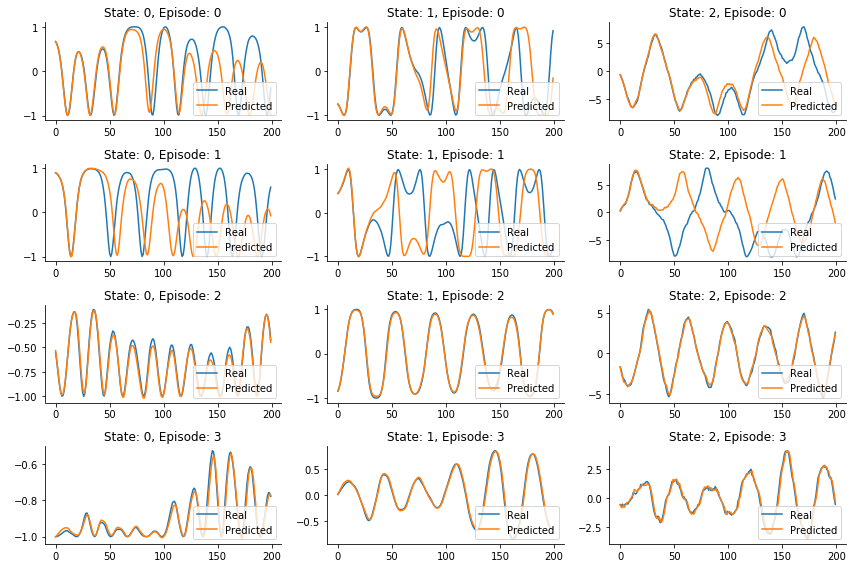

In [9]:
# plot the rolled out predictions for each episode and state
state_size = env.observation_space.shape[-1]
fig, axes = plt.subplots(episodes, state_size, figsize=(12, 8))
for state_dim in range(state_size):
    for episode in range(episodes):
        ax = axes[episode, state_dim]
        ax.plot(next_states[episode, :, state_dim], label='Real')
        ax.plot(next_states_pred[episode, :, state_dim], label='Predicted')
        ax.legend(loc='lower right')
        ax.set_title('State: {}, Episode: {}'.format(state_dim, episode))
sns.despine()
plt.tight_layout()